In [ ]:
# Install required libraries
!pip install torch spacy wordcloud pandas scikit-learn
!python -m spacy download en_core_web_sm  # Download spaCy English model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
%%writefile preprocessing.py
import pandas as pd
import torch
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def fast_tokenize(texts):
    tokens_list = []
    for doc in nlp.pipe(texts, batch_size=1000):
        tokens_list.append([t.lemma_ for t in doc if not t.is_stop and t.is_alpha])
    return tokens_list

def encode_pad(tokens, vocab, max_len=100):
    encoded = [vocab.get(t, 0) for t in tokens[:max_len]]
    return encoded + [0] * (max_len - len(encoded))

def get_preprocessed_data(csv_path):
    df = pd.read_csv(csv_path)
    df['text_'] = df['text_'].astype(str)
    df['tokens'] = fast_tokenize(df['text_'].tolist())
    all_tokens = [t for sublist in df['tokens'] for t in sublist]
    vocab = {word: i+1 for i, (word, _) in enumerate(Counter(all_tokens).most_common(10000))}
    X = torch.tensor([encode_pad(t, vocab) for t in df['tokens']])
    return df, X, vocab

Writing preprocessing.py


In [ ]:
%%writefile models.py
import torch.nn as nn

class MulticlassClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.network = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        embedded = self.embedding(x).mean(dim=1)
        return self.network(embedded)

class BinaryClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.network = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        embedded = self.embedding(x).mean(dim=1)
        return self.network(embedded)

Writing models.py


In [ ]:
# --- Cell 1: Imports ---
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, Dataset
from preprocessing import get_preprocessed_data
from models import MulticlassClassifier

Starting Training...
Epoch 1 complete.
Epoch 2 complete.
Epoch 3 complete.
Epoch 4 complete.
Epoch 5 complete.

Product Category Classification Report:
                              precision    recall  f1-score   support

                     Books_5       0.72      0.70      0.71       874
Clothing_Shoes_and_Jewelry_5       0.78      0.75      0.76       770
               Electronics_5       0.76      0.76      0.76       798
          Home_and_Kitchen_5       0.63      0.64      0.64       811
              Kindle_Store_5       0.76      0.76      0.76       946
             Movies_and_TV_5       0.87      0.86      0.87       717
              Pet_Supplies_5       0.88      0.82      0.85       851
       Sports_and_Outdoors_5       0.54      0.56      0.55       789
Tools_and_Home_Improvement_5       0.65      0.69      0.67       772
            Toys_and_Games_5       0.78      0.80      0.79       759

                    accuracy                           0.73      8087
      

In [ ]:
# --- Cell 2: Custom Dataset Class ---
class ProductReviewDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

Generated Word Cloud for Home_and_Kitchen_5
Generated Word Cloud for Sports_and_Outdoors_5
Generated Word Cloud for Electronics_5
Generated Word Cloud for Movies_and_TV_5
Generated Word Cloud for Tools_and_Home_Improvement_5
Generated Word Cloud for Pet_Supplies_5
Generated Word Cloud for Kindle_Store_5
Generated Word Cloud for Books_5
Generated Word Cloud for Toys_and_Games_5
Generated Word Cloud for Clothing_Shoes_and_Jewelry_5


Generating and displaying images...


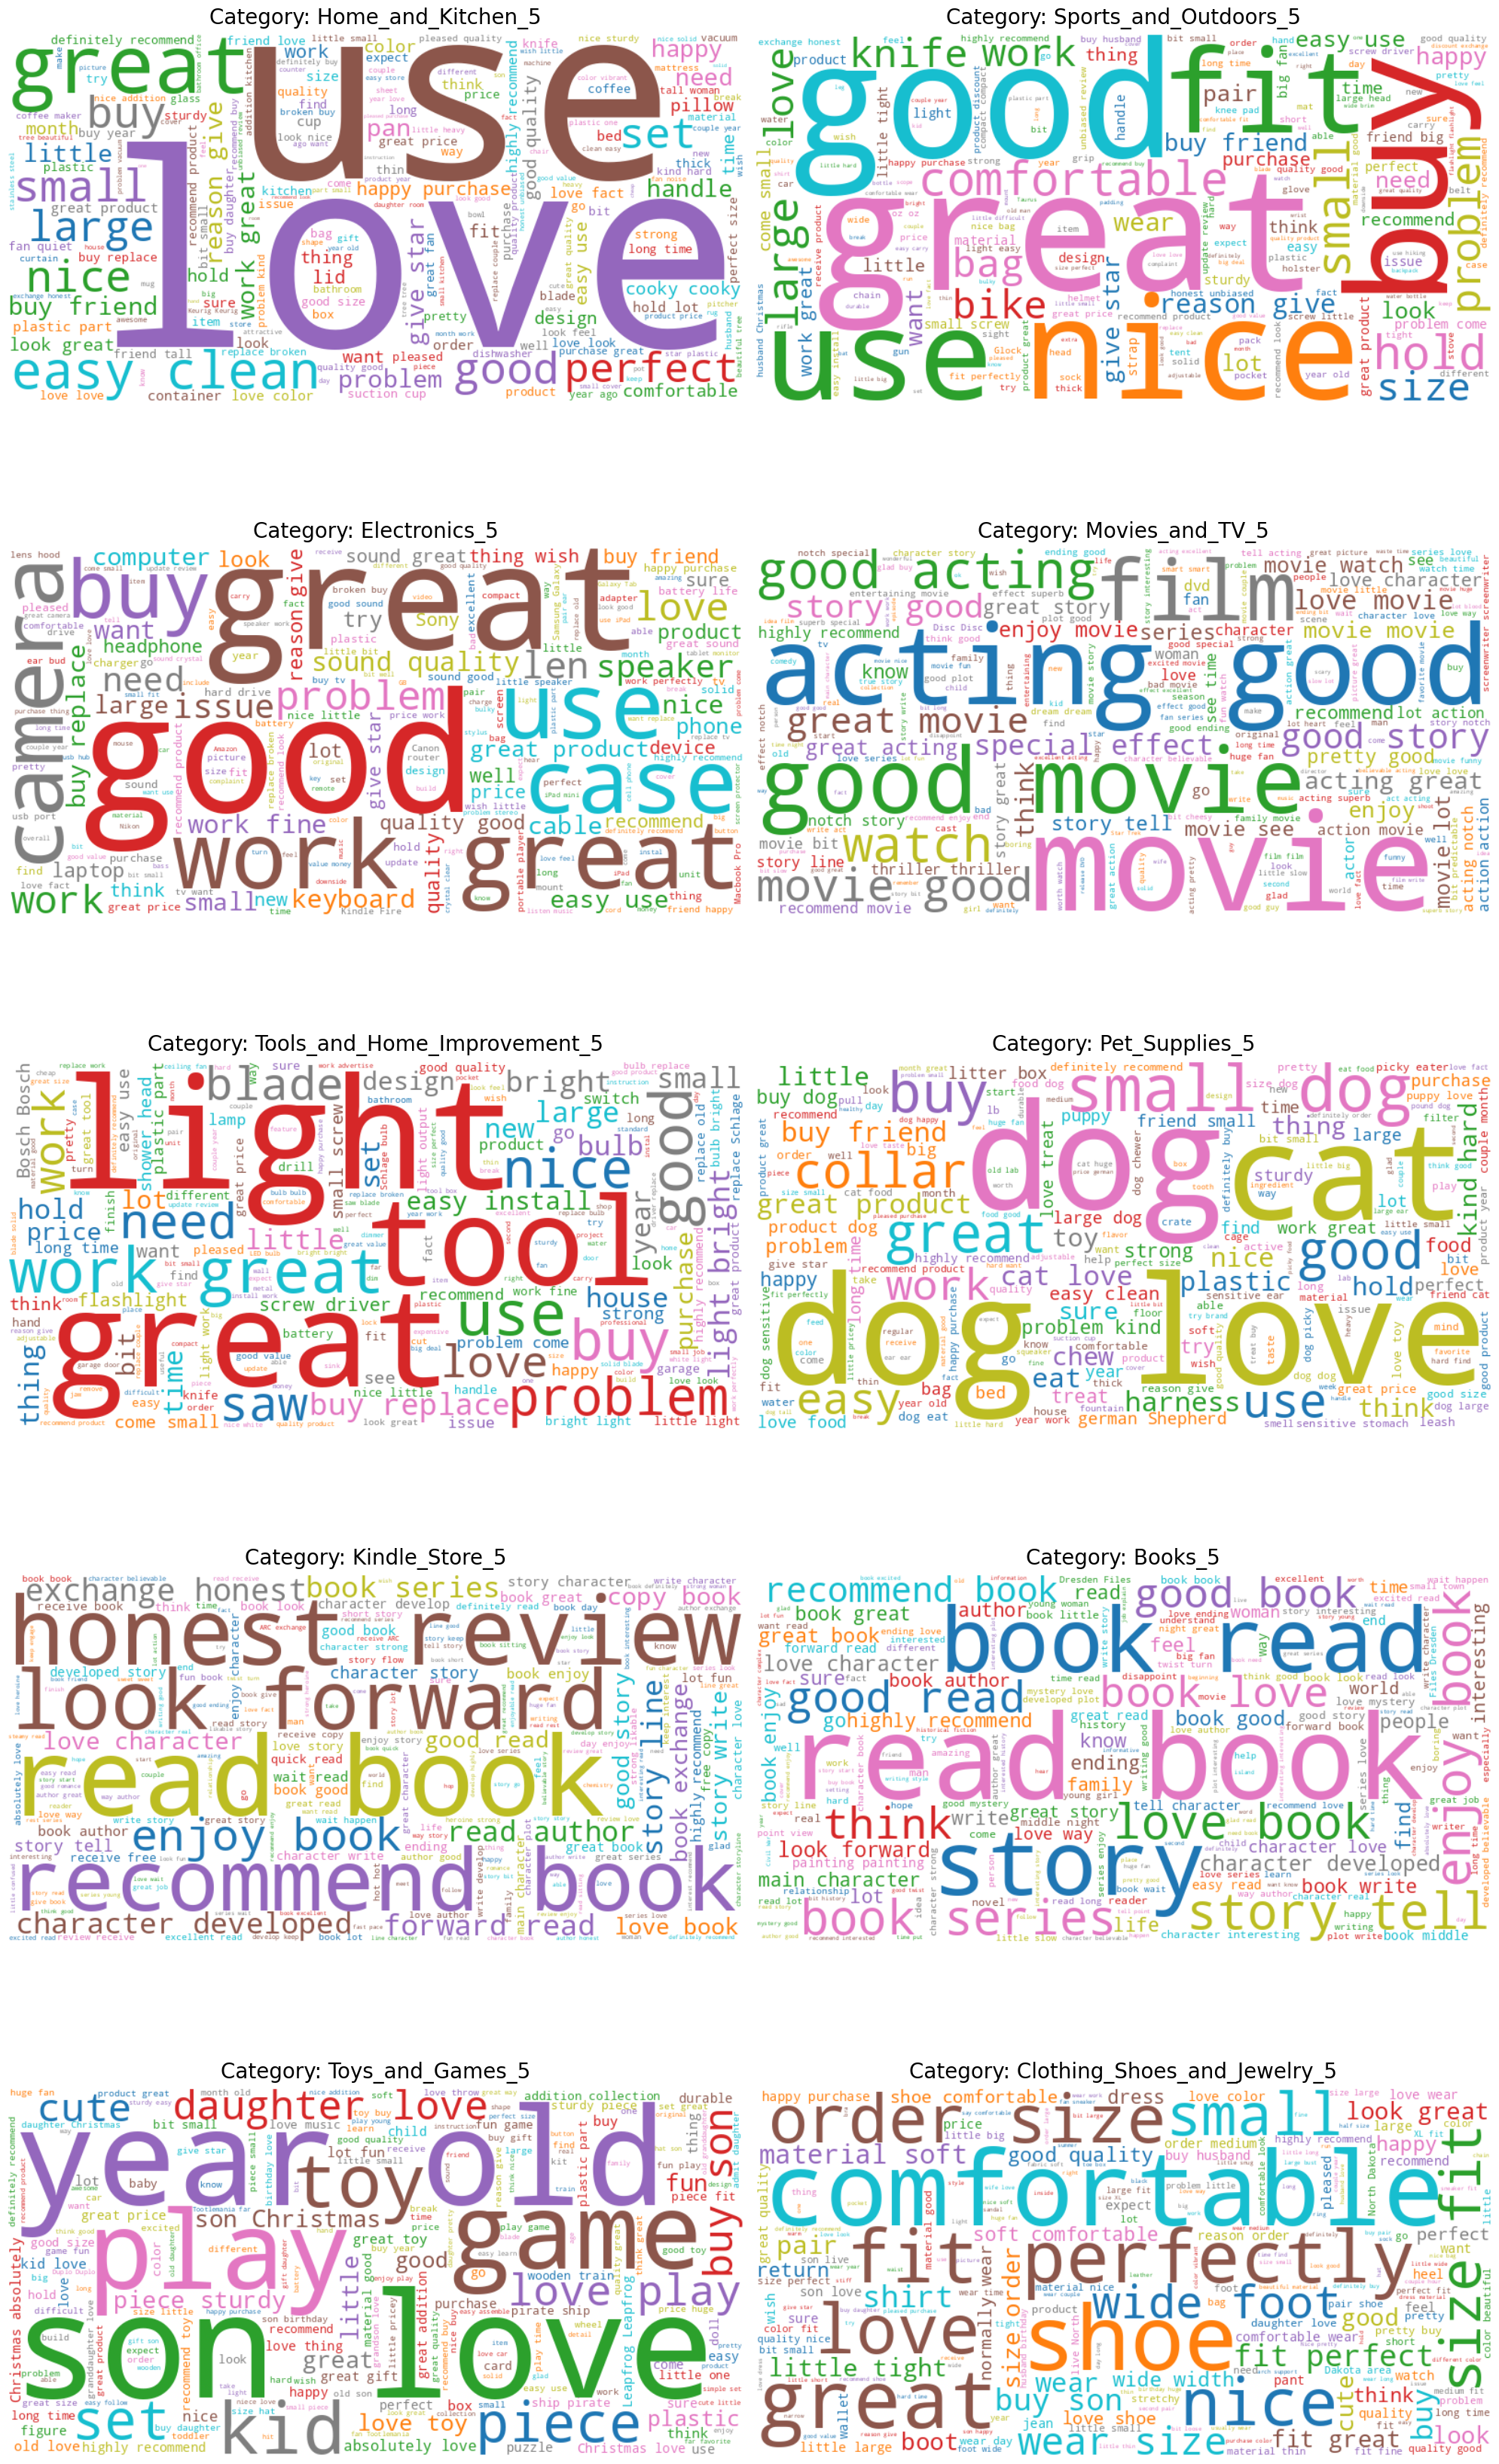

In [ ]:
# --- Cell 3: Load and Prepare Data ---
data_frame, feature_matrix, vocabulary = get_preprocessed_data('fake_reviews_dataset.csv')
category_encoder = LabelEncoder()
category_labels = torch.tensor(category_encoder.fit_transform(data_frame['category']), dtype=torch.long)

# --- Cell 4: Split Data and Create Loader ---
train_indices, test_indices = train_test_split(
    range(len(feature_matrix)),
    test_size=0.2,
    random_state=42,
    stratify=data_frame['category']
)
train_data_loader = DataLoader(
    ProductReviewDataset(feature_matrix[train_indices], category_labels[train_indices]),
    batch_size=64,
    shuffle=True
)
device_type = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Cell 5: Model, Optimizer, Loss ---
classifier_model = MulticlassClassifier(len(vocabulary), 100, len(category_encoder.classes_)).to(device_type)
model_optimizer = torch.optim.Adam(classifier_model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

# --- Cell 6: Training Loop ---
print("Starting Training...")
for epoch_num in range(5):
    classifier_model.train()
    for batch_features, batch_labels in train_data_loader:
        batch_features, batch_labels = batch_features.to(device_type), batch_labels.to(device_type)
        model_optimizer.zero_grad()
        batch_loss = loss_function(classifier_model(batch_features), batch_labels)
        batch_loss.backward()
        model_optimizer.step()
    print(f"Epoch {epoch_num+1} complete.")

# --- Cell 7: Evaluation and Report ---
classifier_model.eval()
predicted_labels = []
with torch.no_grad():
    test_features = feature_matrix[test_indices].to(device_type)
    output_scores = classifier_model(test_features)
    predicted_labels = torch.argmax(output_scores, dim=1).cpu().numpy()

print("\nProduct Category Classification Report:")
print(classification_report(category_labels[test_indices], predicted_labels, target_names=category_encoder.classes_))